## Parte 2 - Tarefa de Classificação
&emsp;Nesta segunda parte, o objetivo é resolver um problema de classificação utilizando dois métodos de aprendizado supervisionado diferentes. \
&emsp;A base de dados utilizada será a Pen-Based Recognition of Handwritten Digits Data Set, disponível na biblioteca sklearn.\
&emsp;Utilizaremos os modelos de aprendizado supervisionado disponíveis no sklearn na solução do problema de classificação.



In [8]:
from sklearn.datasets import load_digits
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE 
from sklearn import tree
import graphviz 
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

%matplotlib notebook

### Importando Dataset
&emsp;Aqui fazemos o import do dataset e separamos ele em treino e teste, na proporção 90/10.

<IPython.core.display.Javascript object>


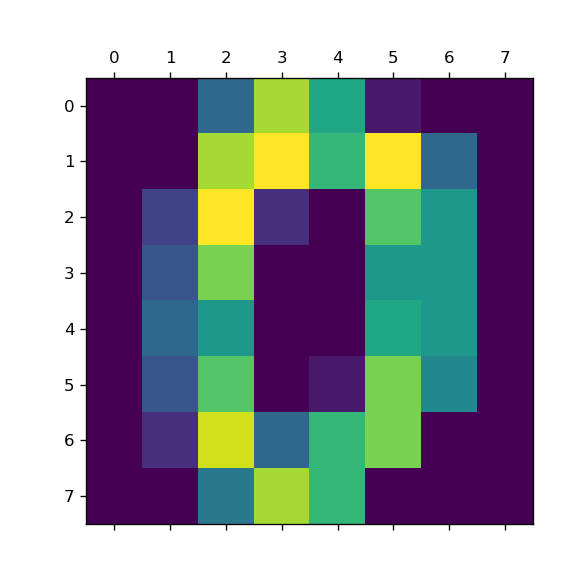

In [9]:
digits = load_digits()

plt.matshow(digits.images[0]) 
plt.show() 


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.1, shuffle=False)

### Visualização dos dados com T-SNE
&emsp;Para a visualização dos nossos dados, escolhemos o modelo T-SNE, que reduz a dimensionalidade dos nossos dados (similar ao PCA) e possibilita a visualização através das duas componentes principais. Podemos observar que os dígitos presentes no dataset formam clusters bem distribuídos e que possui alguns ruídos, por exemplo quando um dígito se distancia de seu cluster e se aproxima de outro.\
&emsp;Assim podemos verificar que temos um dataset bem consolidado e com pouco ruído.

<IPython.core.display.Javascript object>


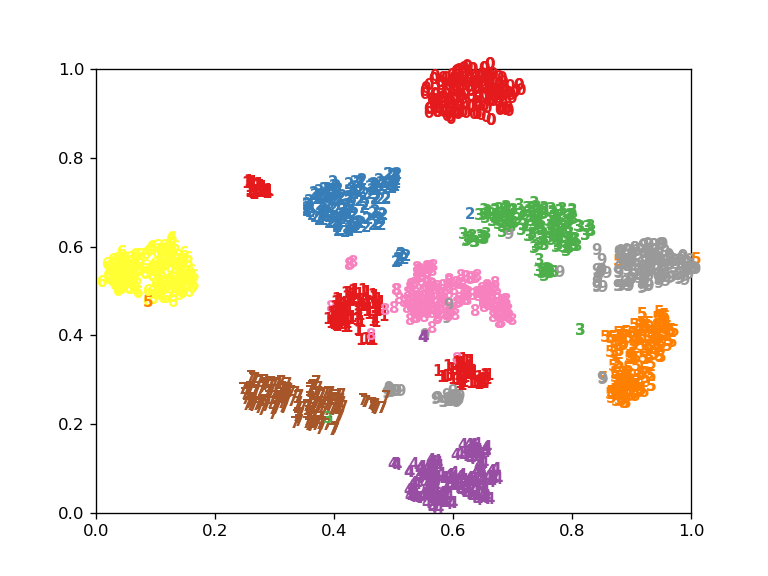

In [11]:
def plot_digits(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})


def plot_tsne(X, y):
    X_embedded = TSNE(n_components=2).fit_transform(X)
    plot_digits(X_embedded, y, "TSNE dos digitos")
    plt.show()
    
plot_tsne(digits.data, digits.target)

### Cross Validation
&emsp;Para nosso treino com cross validation, utilizamos a funcao "cross_validate" e escolhemos o modelo RepeatedKFold com 10 folds e 3 repetições. Utilizamos as métricas de acurácia, recall e f1_score para avaliar os resultados de cada iteração da cross validation.\
&emsp;Assim obtemos os scores obtidos do treinamento com os dados de validação e conseguimos escolher o modelo que possui melhor pontuação no score gerado pelo modelo cross_validate.

In [12]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

scoring_tuple = {'accuracy' : make_scorer(accuracy_score), 
                 'recall_score' : make_scorer(recall_score, average = 'micro'),
                 'f1_score' : make_scorer(f1_score, average = 'micro')}

### Matriz de Confusão

In [13]:
def plot_confusionMatrix(clf, X_test, y_test):
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
    disp.figure_.suptitle("Confusion Matrix")

    plt.show()

### Modelo de Regressão Logística
&emsp;O primeiro modelo de aprendizado supervisionado que escolhemos foi o modelo de regressão logística.  Utilizamos o modelo "LogisticRegression" disponível no sklearn.

Cross-Validation Accuracy Scores [0.95679012 0.9691358  0.94444444 0.96296296 0.9691358  0.95679012
 0.97530864 0.98136646 1.         0.96273292 0.98148148 0.98765432
 0.96296296 0.97530864 0.97530864 0.98148148 0.94444444 0.95031056
 0.96273292 0.95031056 0.97530864 0.97530864 0.97530864 0.95679012
 0.9691358  0.96296296 0.95679012 0.98757764 0.95031056 0.98757764]
Test Score:  0.9333333333333333


<IPython.core.display.Javascript object>


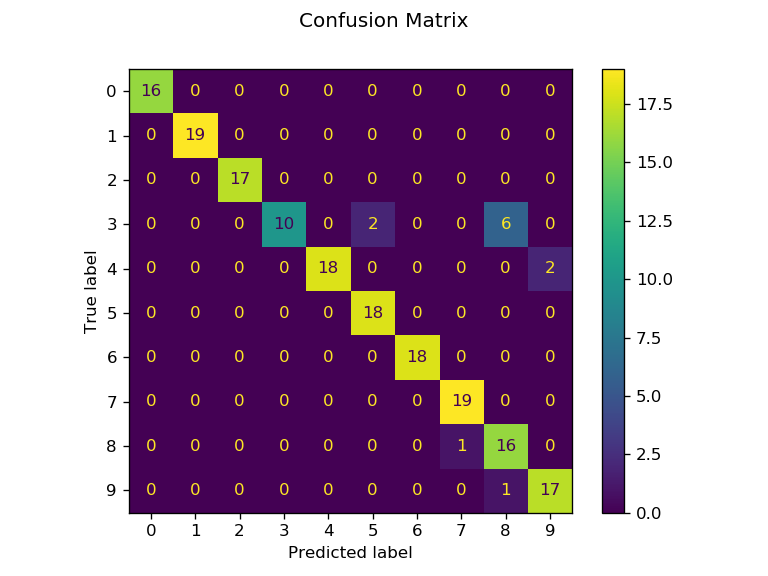

In [14]:
log_reg = LogisticRegression(random_state=0, max_iter=5000)

cv_results = cross_validate(log_reg, X_train, y_train,scoring=scoring_tuple, cv=cv, return_estimator=True)

print('Cross-Validation Accuracy Scores', cv_results['test_accuracy'])

best_model_index = np.argmax(cv_results['test_accuracy'])

best_log_reg = cv_results['estimator'][best_model_index]

predict = best_log_reg.predict(X_test[:])
score = best_log_reg.score(X_test, y_test)
print("Test Score: ",score)
plot_confusionMatrix(best_log_reg, X_test, y_test)

### Modelo de Árvores de Descisão
&emsp;Para nosso segundo modelo, escolhemos o modelo de árvore de descisão utilizando o modelo "DecisionTreeClassifier" disponível no sklearn.\
&emsp;Observamos que os hiperparâmetros "criterion", "max_depth" e "min_impurity_decrease" foram os que apresentaram maior impacto no resultado do modelo. Utilizando o critério de entropia, o modelo conseguiu aprender melhor em cima dos dados, e fixando uma altura máxima para a árvore e um grau de impuridade também ajudaram a controlar o tamanho da árvore de decisão.

Melhor Score:  0.9197530864197531 4
Test Score:  0.85
Cross-Validation Recall Scores 0.85
Cross-Validation F1 Scores 0.85


<IPython.core.display.Javascript object>


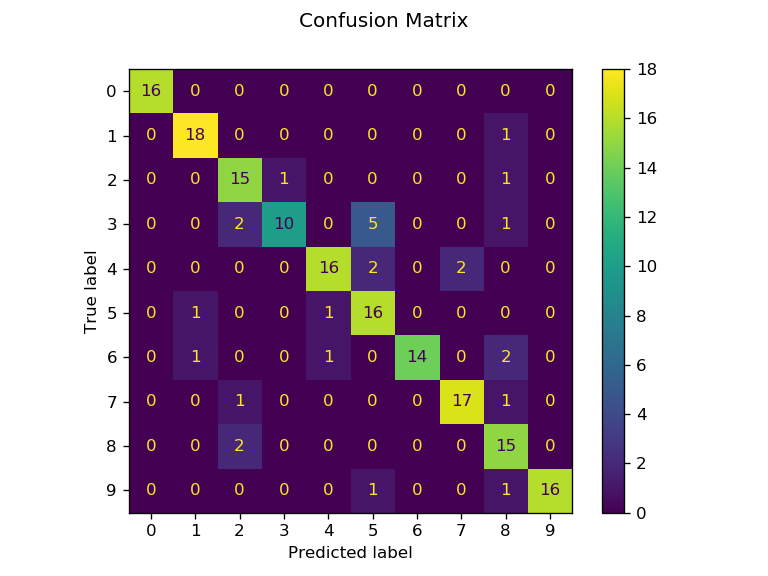

In [19]:
tree_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=9, min_impurity_decrease=0.0002)

cv_results = cross_validate(tree_clf, X_train, y_train, scoring=scoring_tuple, cv=cv, return_estimator=True)

print("Melhor Score: ", np.max(cv_results['test_accuracy']), np.argmax(cv_results['test_accuracy']))
best_model_index = np.argmax(cv_results['test_accuracy'])

best_tree_clf = cv_results['estimator'][best_model_index]

y_pred = predict = best_tree_clf.predict(X_test[:])
score = best_tree_clf.score(X_test, y_test)
print("Test Score: ",score)

print('Cross-Validation Recall Scores', recall_score(y_test, y_pred, average="micro"))
print('Cross-Validation F1 Scores', f1_score(y_test, y_pred, average="micro"))

# tree.plot_tree(best_tree_clf, fontsize=10)
# plt.show()

plot_confusionMatrix(best_tree_clf, X_test, y_test)

In [16]:
r = export_text(best_tree_clf)
print(r)

|--- feature_42 <= 7.50
|   |--- feature_26 <= 8.50
|   |   |--- feature_43 <= 2.50
|   |   |   |--- feature_30 <= 1.50
|   |   |   |   |--- feature_19 <= 8.50
|   |   |   |   |   |--- feature_29 <= 13.50
|   |   |   |   |   |   |--- feature_28 <= 7.50
|   |   |   |   |   |   |   |--- feature_50 <= 6.00
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- feature_50 >  6.00
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- feature_28 >  7.50
|   |   |   |   |   |   |   |--- feature_4 <= 7.50
|   |   |   |   |   |   |   |   |--- feature_29 <= 11.50
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- feature_29 >  11.50
|   |   |   |   |   |   |   |   |   |--- class: 9
|   |   |   |   |   |   |   |--- feature_4 >  7.50
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_29 >  13.50
|   |   |   |   |   |   |--- feature_26 <= 3.50
|   |   |   |   |   |   |   |--- feature_62 <= 6

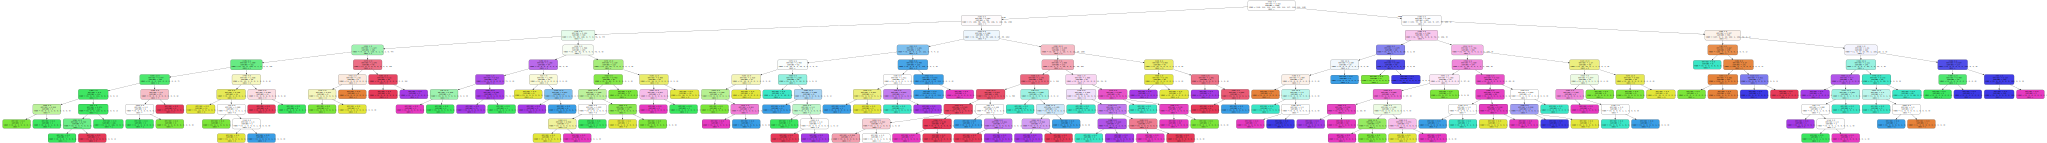

In [17]:
grafico_big = tree.export_graphviz(best_tree_clf, out_file=None, class_names=str(digits.target_names),  
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(grafico_big) 
graph

## Avaliação dos casos de teste e Matriz de Confusão
&emsp;Nesta parte escolhemos nossos melhores modelos obtidos no processo de cross validation, e rodamos eles com o caso de teste, para a avaliação final do modelo. Utilizaremos o modelo de regressão logística, pois pelas nossas observações e pelos pontuações resultantes dos cálculos das métricas (acurácia, recall e f1 score), este modelo foi o que se saiu melhor na fase de cross validation.